<a href="https://colab.research.google.com/github/ojas173/model-predictive-coverage-control/blob/main/MPCC_Sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install casadi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 MB 9.1 MB/s eta 0:00:00


In [2]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, Point, box, LineString
from shapely.ops import polygonize, unary_union
from scipy.linalg import solve_discrete_are
import time

In [3]:
Lx, Ly = 1.0, 1.0           # workspace size
Q_region = box(0, 0, Lx, Ly)
M = 4                         # number of robots
dt = 0.1                      # timestep (s)
sim_steps = 100               # max simulation iterations
grid_density = 30             # grid per cell side for centroid integration (higher -> more accurate)
nx = 4                        # state size
nu = 2                        # input size
N_mpc = 10                    # MPC horizon
max_vel = [np.pi, np.pi/2.1]
max_acc = np.array([1.0, 1.0])
L = 0.005 # Vehicle Wheelbase

Voronoi Partition and Centroid calculator

In [4]:
# @title
# Voronoi Partitions and Centroids
# polypoints = robot positions, bbox = bounding box Q
def bounded_voronoi(polypoints, bbox):
    """
    Compute bounded Voronoi cells for points inside bbox.
    Returns list of shapely Polygons of length = len(polypoints).
    """
    # scipy Voronoi unbounded; we clip cells to bounding box
    pts = np.asarray(polypoints)
    if len(pts) == 1:
        return [bbox]
    vor = Voronoi(pts)
    # build polygon for each region
    regions = []
    for i, point in enumerate(pts):
        region_index = vor.point_region[i]
        region = vor.regions[region_index]
        if -1 in region:  # unbounded region -> clip with bbox
            # approximate by taking voronoi ridges and intersecting rays with bbox edges
            # easier: build large polygon from ridges, then intersect with bbox
            # We'll reconstruct the cell as intersection of half-planes: for each other point j,
            # the halfplane { x | ||x - p_i|| <= ||x - p_j|| }.
            cell = bbox
            pi = point
            for j, pj in enumerate(pts):
                if j == i: continue
                # perpendicular bisector between pi and pj: line ax+by+c=0
                mid = 0.5*(pi + pj)
                # normal vector from pj to pi
                n = np.array(pi) - np.array(pj)
                if np.linalg.norm(n) < 1e-8:
                    continue
                # define a large polygon half-space via a line
                # build a line across bbox and take half that contains pi
                # create a long line segment orthogonal to n passing near mid
                dir_vec = np.array([-n[1], n[0]])
                p1 = mid + dir_vec * max(Lx, Ly) * 10
                p2 = mid - dir_vec * max(Lx, Ly) * 10
                half_line = LineString([tuple(p1), tuple(p2)])
                # create large polygon for half-plane
                coords = [tuple(p1), tuple(p2),
                          (p2[0] + n[0]*1e6, p2[1] + n[1]*1e6),
                          (p1[0] + n[0]*1e6, p1[1] + n[1]*1e6)]
                half_poly = Polygon(coords)
                # choose which half contains pi
                if not half_poly.contains(Point(tuple(pi))):
                    half_poly = Polygon(list(half_poly.exterior.coords)[::-1])
                cell = cell.intersection(half_poly)
                if cell.is_empty:
                    break
            regions.append(cell)
        else:
            polygon = Polygon([vor.vertices[v] for v in region])
            regions.append(polygon.intersection(bbox))
    # ensure order corresponds to input points
    # convert possible GeometryCollections to Polygons
    final = []
    for g in regions:
        if g.geom_type == 'Polygon':
            final.append(g)
        elif g.is_empty:
            final.append(Polygon())
        else:
            # unify and take convex hull fallback
            try:
                gp = unary_union(g)
                final.append(gp.convex_hull.intersection(bbox))
            except Exception:
                final.append(Polygon())
    return final

# -------------------------
# Sensor density (Phi)
# -------------------------
def phi_uniform(xy):
    # uniform density (constant)
    return 1.0

def weighted_centroid_of_polygon(poly, phi=phi_uniform, samples_per_side=20):
    """
    Numerically estimate weighted centroid over polygon using grid sampling.
    Returns centroid (x,y) and mass.
    """
    if poly.is_empty or not poly.is_valid:
        return np.array([np.nan, np.nan]), 0.0
    minx, miny, maxx, maxy = poly.bounds
    if minx == maxx or miny == maxy:
        # degenerate cell
        pts = np.array(poly.exterior.coords)
        c = np.mean(pts, axis=0)
        return c, 1.0
    nx = samples_per_side
    ny = samples_per_side
    xs = np.linspace(minx, maxx, nx)
    ys = np.linspace(miny, maxy, ny)
    X, Y = np.meshgrid(xs, ys)
    pts = np.vstack([X.ravel(), Y.ravel()]).T
    mask = np.array([poly.contains(Point(p)) or poly.touches(Point(p)) for p in pts])
    pts_in = pts[mask]
    if pts_in.shape[0] == 0:
        # fallback centroid of polygon geometry
        c = np.array(poly.representative_point().coords[0])
        return c, 1.0
    vals = np.array([phi(p) for p in pts_in])
    mass = vals.sum()
    if mass == 0:
        c = pts_in.mean(axis=0)
        return c, 0.0
    centroid = (vals[:, None] * pts_in).sum(axis=0) / mass
    return centroid, mass

Dynamic Model and State Clipper

In [5]:
# @title
def dynamic_model(x, u):
  # x = [px, py, theta, gamma] ; theta = yaw, gamma = steering angle
  # u = [v, delta] ; v = veloctiy, delta = steering rate
  px = x[0]
  py = x[1]
  theta = x[2]
  gamma = x[3]
  v = u[0]
  delta = u[1]
  px_next = px + v * ca.cos(theta) * dt
  py_next = py + v * ca.sin(theta) * dt
  theta_next = theta + v / L * ca.tan(gamma) * dt
  gamma_next = gamma + delta * dt
  return ca.vertcat(px_next, py_next, theta_next, gamma_next)
'''
def dynamic_model_function(x, u):
  # x = [px, py, theta, gamma] ; theta = yaw, gamma = steering angle
  # u = [v, delta] ; v = veloctiy, delta = steering rate
  px = x[0]
  py = x[1]
  theta = x[2]
  gamma = x[3]
  v = u[0]
  delta = u[1]
  px_next = px + v * ca.cos(theta) * dt
  py_next = py + v * ca.sin(theta) * dt
  theta_next = theta + v / L * ca.tan(gamma) * dt
  gamma_next = gamma + delta * dt
  x_next = ca.vertcat(px_next, py_next, theta_next, gamma_next)
  f_dyn = ca.Function('f_dyn', [x, u], [x_next])
  return f_dyn
'''



# Keeping the robot within the bounding box
def clip_state(x):
    # position inside Q, velocity limits
    x = x.copy()
    x[0] = np.clip(x[0], 0, Lx)
    x[1] = np.clip(x[1], 0, Ly)
    x[2] = np.clip(x[2], -max_vel[0], max_vel[0])
    x[3] = np.clip(x[3], -max_vel[1], max_vel[1])
    return x


Coverage Cost

In [6]:
# @title
# small helper for coverage cost approx H(p,W) using Monte Carlo grid
def approx_coverage_cost(points, cells, phi=phi_uniform, gfun=lambda d: d**2, samples=400):
    # approximate integral by sampling a grid over workspace
    xs = np.linspace(0, Lx, int(np.sqrt(samples)))
    ys = np.linspace(0, Ly, int(np.sqrt(samples)))
    X, Y = np.meshgrid(xs, ys)
    pts = np.vstack([X.ravel(), Y.ravel()]).T
    total = 0.0
    for p_i, cell in zip(points, cells):
        # pick samples inside cell
        mask = np.array([cell.contains(Point(pt)) or cell.touches(Point(pt)) for pt in pts])
        if mask.sum() == 0:
            continue
        pts_in = pts[mask]
        dists = np.linalg.norm(pts_in - p_i, axis=1)
        vals = gfun(dists) * np.array([phi(pt) for pt in pts_in])
        total += vals.mean() * cell.area
    return total

# Algorithm 1 Only

In [8]:
# Cost weights
Q_stage = np.diag([1000, 1000, 0, 100])   # state error weight
R_stage = np.diag([1, 100]) #1 * np.eye(2)           # input weight
Q_terminal = np.diag([1, 1, 1, 1])

MPC Problem Builder Without Terminal LQR

In [9]:
# @title
# Build MPC
def build_mpc_problem(nx=nx, nu=nu, N=N_mpc):
    X = ca.SX.sym('X', nx, N+1)
    U = ca.SX.sym('U', nu, N)
    x0 = ca.SX.sym('x0', nx)
    xbar = ca.SX.sym('xbar', nx)  # steady state to track
    ubar = ca.SX.sym('ubar', nu)
    # stage cost matrices as CasADi
    Qc = ca.DM(Q_stage)
    Rc = ca.DM(R_stage)
    QN = ca.DM(Q_terminal)
    obj = 0
    g = []
    # initial cond
    g.append(X[:,0] - x0)
    for k in range(N):
        # dynamics: explicit Euler discrete mapping f_dynamics
        x_next = dynamic_model(X[:,k], U[:,k])
        g.append(X[:,k+1] - x_next)
        dx = X[:,k] - xbar
        du = U[:,k] - ubar
        obj = obj + ca.mtimes([dx.T, Qc, dx]) + ca.mtimes([du.T, Rc, du])
    # terminal cost
    dxN = X[:,N] - xbar
    obj = obj + ca.mtimes([dxN.T, QN, dxN])
    # bounds and constraints will be added in solver call (as functions)
    # pack decision vars
    dec_vars = ca.vertcat(ca.reshape(X, -1, 1), ca.reshape(U, -1, 1))
    # Pack NLP
    g_all = ca.vertcat(*g)
    p = ca.vertcat(x0, xbar, ubar)
    nlp = {'x': dec_vars, 'f': obj, 'g': g_all, 'p': p}
    # Create solver
    opts = {'ipopt.print_level': 0, 'print_time': 0}
    solver = ca.nlpsol('solver', 'ipopt', nlp, opts)

    return solver

MPC Solver Without Terminal LQR

In [10]:
# @title
# Solve MPC
def solve_mpc_casadi(solver, x0_val, xbar_val, ubar_val, nx=nx, nu=nu, N=N_mpc):
    """
    Build a small NLP each call. For clarity and simplicity we rebuild constraints inline using CasADi.
    For performance, a compiled solver/interface would be better (keep solver object), but this template is clear.
    """
    # initial guess
    x_init = np.tile(x0_val.reshape(-1,1), (1, N+1))
    u_init = np.zeros((nu, N))
    dec_init = np.vstack([x_init.reshape(-1,1), u_init.reshape(-1,1)])
    # bounds for g (dynamics equality)
    ng = nx*(N+1)
    lbg = np.zeros((ng,1))
    ubg = np.zeros((ng,1))
    # bounds for dec vars: we won't impose here; instead we later clip applied input
    p_val = np.vstack([x0_val.reshape(-1,1), xbar_val.reshape(-1,1), ubar_val.reshape(-1,1)])
    try:
        sol = solver(x0=dec_init, lbg=lbg, ubg=ubg, p=p_val)
        dec_sol = sol['x'].full().flatten()
        # extract first control
        x_vars = dec_sol[:nx*(N+1)].reshape((nx, N+1))
        u_vars = dec_sol[nx*(N+1):].reshape((nu, N))
        u0 = u_vars[:,0]
    except Exception as e:
        # infeasible or solver failure -> fallback to zero accel
        print("MPC solver failed:", e)
        u0 = np.zeros(2)
    # clip inputs
    u0 = np.clip(u0, -max_acc, max_acc)
    return u0

Initialize Simulation

In [11]:
# @title
#Initialize Simulation
np.random.seed(2)
# initial robot states: random positions, zero velocity
x = np.zeros((M, 4))
#x[:, 0:2] = np.random.rand(M, 2) * np.array([Lx, Ly])
x[:, 0:2] = np.array([[0.51, 0.51], [0.49, 0.49], [0.49, 0.51], [0.51, 0.49]])
# initial references (centroids) computed from initial Voronoi
ps = x[:, :2].copy()
cells = bounded_voronoi(ps, Q_region)
centroids = np.zeros((M,2))
mass_list = np.zeros(M)
for i in range(M):
    c, mass = weighted_centroid_of_polygon(cells[i], phi_uniform, samples_per_side=grid_density)
    if mass == 0:
        c = ps[i]
    centroids[i] = c
    mass_list[i] = mass
# per-agent tracking error initial
e_r = np.linalg.norm(ps - centroids, axis=1)

# logging
traj = [ps.copy()]
H_vals = []
mpc_solver = build_mpc_problem()
x_sym = ca.SX.sym('x_sym', nx)
u_sym = ca.SX.sym('u_sym', nu)
f_dynamics = ca.Function('f_dyn', [x_sym, u_sym], [dynamic_model(x_sym, u_sym)])
print("Initial Position:", x[:, 0:2])
print("Simulation Loop ready to be run.")

Initial Position: [[0.51 0.51]
 [0.49 0.49]
 [0.49 0.51]
 [0.51 0.49]]
Simulation Loop ready to be run.


Simulation Loop

In [13]:
# @title
# Simulation Loop
print("Starting simulation...")
start_time = time.time()
for k in range(sim_steps):
    # compute Voronoi and centroids (based on current positions)
    ps = x[:, :2].copy()
    cells = bounded_voronoi(ps, Q_region)
    centroids_current = np.zeros((M,2))
    masses = np.zeros(M)
    for i in range(M):
        c, mass = weighted_centroid_of_polygon(cells[i], phi_uniform, samples_per_side=grid_density)
        if mass == 0:
            c = ps[i]
        centroids_current[i] = c
        masses[i] = mass

    # for each agent: compute MPC to track its current reference ri (which is centroids[i] from last update)
    # The algorithm in the paper sets ri to computed centroid at initialization, then only updates ri when condition met.
    # To mimic that, we will store ri, ei,r, and update ri only when condition satisfied.
    # For start: if first iteration, we set ri as previously computed centroids (done above at init)
    if k == 0:
        ri = centroids.copy()
    # apply MPC for each agent to track ri[i]
    for i in range(M):
        x0 = x[i].copy()
        # build xbar (steady state) from ri: we choose steady state with zero velocity, so xbar = [rx, ry, 0,0]
        xbar = np.array([ri[i,0], ri[i,1], 0., 0.])
        ubar = np.zeros(2)
        # solve MPC
        u0 = solve_mpc_casadi(mpc_solver, x0, xbar, ubar)
        # apply input, propagate dynamics
        x_next = f_dynamics(x0, u0).full().flatten()
        x_next = clip_state(x_next)
        x[i] = x_next
        #if k <= 10 and i == 1:
          #print("x0 =", x0, "; u0 =", u0, "; x_next =", x_next, "; xbar =", xbar)
    # After all agents applied first input, compute condition for updating ri (lines 8-10)
    ps_new = x[:, :2].copy()
    # check not-increased condition
    dist_to_ri = np.linalg.norm(ps_new - ri, axis=1)
    non_increase = np.all(dist_to_ri <= e_r + 1e-9)
    decreased_any = np.any(dist_to_ri < e_r - 1e-9)
    if non_increase and decreased_any:
        # update ri to new centroids computed from current positions (centroids_current)
        ri = centroids_current.copy()
        e_r = np.linalg.norm(ps_new - ri, axis=1)
        # (this is centralized step in algorithm)
    else:
        # keep e_r as distances to current ri if not updated
        e_r = dist_to_ri.copy()

    # log
    traj.append(x[:, :2].copy())
    H_vals.append(approx_coverage_cost(ps_new, cells, phi_uniform, gfun=lambda d: d**2, samples=400))
    # stop if robots near centroids (converged)
    if np.max(np.linalg.norm(ps_new - centroids_current, axis=1)) < 0.05:
        print(f"Converged by iteration {k}")
        break

end_time = time.time()
print("Simulation finished in {:.2f}s".format(end_time - start_time))

Starting simulation...
Simulation finished in 26.96s


# Algorithm 1 and 2

In [30]:
# Cost weights
Q_stage = np.diag([2, 2, 0.02, 0.01])   # state error weight
R_stage = np.diag([0.08, 0.02])               # input weight

Linearizer

In [16]:
# @title
def linearize_dynamics(xbar, ubar, nx=nx, nu=nu):
    """
    Compute linearization A,B of f around (xbar, ubar).
    f_sym_callable should accept CasADi SX vectors: f_sym_callable(X, U) -> SX vector.
    Returns numeric numpy arrays A, B.
    """
    X = ca.SX.sym('X', nx)
    U = ca.SX.sym('U', nu)

    # Create a CasADi function for the dynamics
    f_sym = dynamic_model(X, U)
    f_func = ca.Function('f_func', [X, U], [f_sym])

    # Compute Jacobians symbolically
    A_sym = ca.jacobian(f_sym, X)
    B_sym = ca.jacobian(f_sym, U)

    # Create a CasADi function for the Jacobians
    jac_func = ca.Function('jac_func', [X, U], [A_sym, B_sym])

    # Evaluate Jacobians numerically at the linearization point
    A_c, B_c = jac_func(xbar, ubar)
    A = np.array(A_c)
    B = np.array(B_c)
    return A, B

def dlqr(A, B, Q, R):
    """Discrete LQR via solve_discrete_are. Returns K,P (numpy)."""
    P = solve_discrete_are(A, B, Q, R)
    K = -np.linalg.inv(R + B.T @ P @ B) @ (B.T @ P @ A)
    # P = 0.5 * (P + P.T)  # ensure symmetry -- why is this needed?
    return K, P

MPC Builder With Terminal LQR

In [17]:
# @title
# Build MPC
def build_mpc_problem(nx=nx, nu=nu, N=N_mpc, Q_stage=Q_stage, R_stage=R_stage,
                      xbar_lin=None, ubar_lin=None,
                      u_min=-max_acc, u_max=max_acc):
    # Building the linearizer problem
    # Reference is position independent, and terminal velocity & acceleration is 0
    # Linearize around a state with small non-zero velocity for controllability
    xbar_lin = np.zeros(nx)
    ubar_lin = np.zeros(nu)
    xbar_lin[2] = 0.1  # Small non-zero velocity in x direction
    ubar_lin[0] = 0.1  # Small non-zero velocity
    # A, B
    X_lin = ca.SX.sym('X', nx)
    U_lin = ca.SX.sym('U', nu)
    A_lin, B_lin = linearize_dynamics(xbar_lin, ubar_lin, nx=nx, nu=nu)

    print("A matrix before dlqr:", A_lin)
    print("B matrix before dlqr:", B_lin)

    # K, P
    K, P = dlqr(A_lin, B_lin, Q_stage, R_stage)
    # alpha
    invP = np.linalg.inv(P)
    quad_vals = np.array([K[j:j+1, :] @ invP @ K[j:j+1, :].T for j in range(nu)]).flatten()
    alpha1_candidates = []
    for j in range(nu):
        if quad_vals[j] <= 0:
            alpha1_candidates.append(np.inf)
        else:
            alpha1_candidates.append((u_max[j]**2) / float(quad_vals[j]))
    alpha1 = min(alpha1_candidates)
    alpha = 0.5 * alpha1  # conservative margin - can solve for optimal if required

    # Build MPC
    X = ca.SX.sym('X', nx, N+1)
    U = ca.SX.sym('U', nu, N)
    x0 = ca.SX.sym('x0', nx)
    xbar = ca.SX.sym('xbar', nx)  # steady state to track
    ubar = ca.SX.sym('ubar', nu)
    # stage cost matrices as CasADi
    Qc = ca.DM(Q_stage)
    Rc = ca.DM(R_stage)
    QN = ca.DM(P)
    obj = 0
    g = []
    # initial cond
    g.append(X[:,0] - x0)
    for k in range(N):
        # dynamics: explicit Euler discrete mapping f_dynamics
        x_next = dynamic_model(X[:,k], U[:,k])
        g.append(X[:,k+1] - x_next)
        dx = X[:,k] - xbar
        du = U[:,k] - ubar
        obj = obj + ca.mtimes([dx.T, Qc, dx]) + ca.mtimes([du.T, Rc, du])
    # terminal cost
    dxN = X[:,N] - xbar
    obj = obj + ca.mtimes([dxN.T, QN, dxN])
    # Adding terminal constraint x_N' P x_N - α <= 0
    g.append(ca.mtimes([X[:, N].T, QN, X[:, N]]) - float(alpha))
    # Pack decision variables
    dec_vars = ca.vertcat(ca.reshape(X, -1, 1), ca.reshape(U, -1, 1))
    # Pack NLP
    g_all = ca.vertcat(*g)
    p = ca.vertcat(x0, xbar, ubar)
    nlp = {'x': dec_vars, 'f': obj, 'g': g_all, 'p': p}
    # Create solver
    opts = {'ipopt.print_level': 0, 'print_time': 0}
    solver = ca.nlpsol('solver', 'ipopt', nlp, opts)

    return solver, {'P': P, 'K': K, 'alpha': alpha}

MPC Solver With Terminal LQR

In [18]:
# @title
# Solve MPC
def solve_mpc_casadi(solver, P, alpha, x0_val, xbar_val, ubar_val, nx=nx, nu=nu, N=N_mpc):
    """
    Build a small NLP each call. For clarity and simplicity we rebuild constraints inline using CasADi.
    For performance, a compiled solver/interface would be better (keep solver object), but this template is clear.
    """
    # initial guess
    x_init = np.tile(x0_val.reshape(-1,1), (1, N+1))
    u_init = np.zeros((nu, N))
    dec_init = np.vstack([x_init.reshape(-1,1), u_init.reshape(-1,1)])
    # bounds for g (dynamics equality)
    # Get the number of constraints from the solver object
    ng = nx * (N + 1) + 1
    lbg = np.zeros((ng,1))
    ubg = np.zeros((ng,1))
    # The terminal constraint x_N' P x_N - α <= 0 means the upper bound for this constraint is 0
    lbg[-1] = -np.inf  # allow anything below 0
    ubg[-1] = 0        # enforce x_N^T P x_N - α <= 0
    # bounds for dec vars: we won't impose here; instead we later clip applied input
    p_val = np.vstack([x0_val.reshape(-1,1), xbar_val.reshape(-1,1), ubar_val.reshape(-1,1)])
    try:
        sol = solver(x0=dec_init, lbg=lbg, ubg=ubg, p=p_val)
        dec_sol = sol['x'].full().flatten()
        # extract first control
        x_vars = dec_sol[:nx*(N+1)].reshape((nx, N+1))
        u_vars = dec_sol[nx*(N+1):].reshape((nu, N))
        u0 = u_vars[:,0]

        # Terminal constraint check
        xN = x_vars[:, -1]
        x_diff = xN - xbar_val
        V_terminal = x_diff.T @ P @ x_diff
        if V_terminal > alpha:
            print("Warning: terminal constraint violated. V =", float(V_terminal))

    except Exception as e:
        # infeasible or solver failure -> fallback to zero accel
        print("MPC solver failed:", e)
        u0 = np.zeros(2)
    # clip inputs
    u0 = np.clip(u0, -max_acc, max_acc)
    return u0

Initialize Simulation

In [31]:
# @title
#Initialize Simulation
np.random.seed(2)
# initial robot states: random positions, zero velocity
x = np.zeros((M, 4))
#x[:, 0:2] = np.random.rand(M, 2) * np.array([Lx, Ly])
x[:, 0:2] = np.array([[0.51, 0.51], [0.49, 0.49], [0.49, 0.51], [0.51, 0.49]])
# initial references (centroids) computed from initial Voronoi
ps = x[:, :2].copy()
cells = bounded_voronoi(ps, Q_region)
centroids = np.zeros((M,2))
mass_list = np.zeros(M)
for i in range(M):
    c, mass = weighted_centroid_of_polygon(cells[i], phi_uniform, samples_per_side=grid_density)
    if mass == 0:
        c = ps[i]
    centroids[i] = c
    mass_list[i] = mass
# per-agent tracking error initial
e_r = np.linalg.norm(ps - centroids, axis=1)

# logging
traj = [ps.copy()]
H_vals = []
mpc_solver, terminal = build_mpc_problem()
x_sym = ca.SX.sym('x_sym', nx)
u_sym = ca.SX.sym('u_sym', nu)
f_dynamics = ca.Function('f_dyn', [x_sym, u_sym], [dynamic_model(x_sym, u_sym)])
P_term = terminal['P']
K_term = terminal['K']
alpha_term = terminal['alpha']
print("Built MPC solver with terminal ingredients:")
print("  alpha =", alpha_term, "\n P = ", P_term, "\n K = ", K_term)
print("Initial Position:", x[:, 0:2])
print("Simulation Loop ready to be run.")

A matrix before dlqr: [[ 1.00000000e+00  0.00000000e+00 -9.98334166e-04  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  9.95004165e-03  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  2.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
B matrix before dlqr: [[0.09950042 0.        ]
 [0.00998334 0.        ]
 [0.         0.        ]
 [0.         0.1       ]]
Built MPC solver with terminal ingredients:
  alpha = 0.0202072906456937 
 P =  [[ 4.85346402 -2.47085822 -0.10235154 -0.28817692]
 [-2.47085822 29.23171656  1.02010137  2.87215693]
 [-0.10235154  1.02010137  0.12643088  0.39661044]
 [-0.28817692  2.87215693  0.39661044  2.16616569]] 
 K =  [[-4.32089062e+00 -4.33535143e-01  6.37327871e-16  2.12477658e-15]
 [ 6.91707785e-01 -6.89400553e+00 -1.02126571e+00 -7.10338183e+00]]
Initial Position: [[0.51 0.51]
 [0.49 0.49]
 [0.49 0.51]
 [0.51 0.49]]
Simulation Loop ready to be run.


Simulation Loop

In [32]:
# @title
# Simulation Loop
print("Starting simulation...")
start_time = time.time()
for k in range(sim_steps):
    # compute Voronoi and centroids (based on current positions)
    ps = x[:, :2].copy()
    cells = bounded_voronoi(ps, Q_region)
    centroids_current = np.zeros((M,2))
    masses = np.zeros(M)
    for i in range(M):
        c, mass = weighted_centroid_of_polygon(cells[i], phi_uniform, samples_per_side=grid_density)
        if mass == 0:
            c = ps[i]
        centroids_current[i] = c
        masses[i] = mass

    # for each agent: compute MPC to track its current reference ri (which is centroids[i] from last update)
    # The algorithm in the paper sets ri to computed centroid at initialization, then only updates ri when condition met.
    # To mimic that, we will store ri, ei,r, and update ri only when condition satisfied.
    # For start: if first iteration, we set ri as previously computed centroids (done above at init)
    if k == 0:
        ri = centroids.copy()
    # apply MPC for each agent to track ri[i]
    for i in range(M):
        x0 = x[i].copy()
        # build xbar (steady state) from ri: we choose steady state with zero velocity, so xbar = [rx, ry, 0,0]
        xbar = np.array([ri[i,0], ri[i,1], 0., 0.])
        ubar = np.zeros(2)
        # solve MPC
        u0 = solve_mpc_casadi(mpc_solver, P_term, alpha_term, x0, xbar, ubar)
        # apply input, propagate dynamics
        x_next = f_dynamics(x0, u0).full().flatten()
        x_next = clip_state(x_next)
        x[i] = x_next
        #if k <= 10 and i == 1:
          #print("x0 =", x0, "; u0 =", u0, "; x_next =", x_next, "; xbar =", xbar)
    # After all agents applied first input, compute condition for updating ri (lines 8-10)
    ps_new = x[:, :2].copy()
    # check not-increased condition
    dist_to_ri = np.linalg.norm(ps_new - ri, axis=1)
    non_increase = np.all(dist_to_ri <= e_r + 1e-9)
    decreased_any = np.any(dist_to_ri < e_r - 1e-9)
    if non_increase and decreased_any:
        # update ri to new centroids computed from current positions (centroids_current)
        ri = centroids_current.copy()
        e_r = np.linalg.norm(ps_new - ri, axis=1)
        # (this is centralized step in algorithm)
    else:
        # keep e_r as distances to current ri if not updated
        e_r = dist_to_ri.copy()

    # log
    traj.append(x[:, :2].copy())
    H_vals.append(approx_coverage_cost(ps_new, cells, phi_uniform, gfun=lambda d: d**2, samples=400))
    # stop if robots near centroids (converged)
    if np.max(np.linalg.norm(ps_new - centroids_current, axis=1)) < 0.05:
        print(f"Converged by iteration {k}")
        break

end_time = time.time()
print("Simulation finished in {:.2f}s".format(end_time - start_time))

Starting simulation...
Simulation finished in 45.55s


# Visualization

Movement and Cost Graph

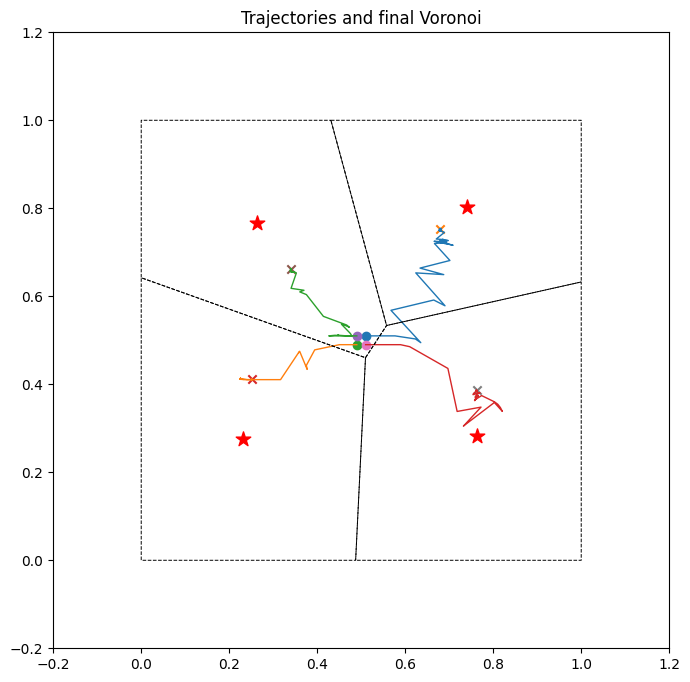

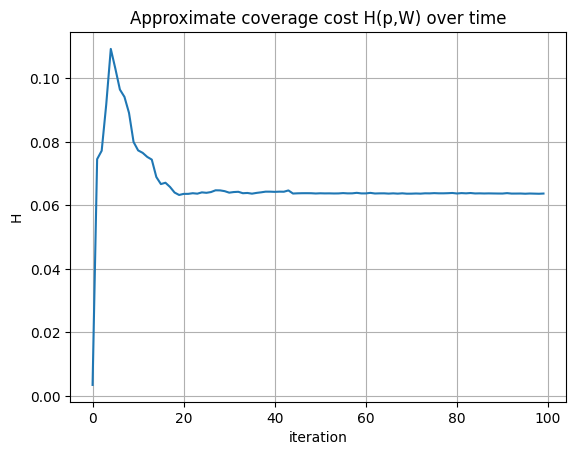

In [33]:
# @title
# Graphs
traj = np.array(traj)  # (T, M, 2)
T = traj.shape[0]

plt.figure(figsize=(8,8))
# plot workspace
plt.xlim(0-0.2, Lx+0.2); plt.ylim(0-0.2, Ly+0.2)
# plot trajectories
for i in range(M):
    plt.plot(traj[:, i, 0], traj[:, i, 1], '-', linewidth=1)
    plt.scatter(traj[0, i, 0], traj[0, i, 1], marker='o', label=f'robot{i}' if i==0 else None)
    plt.scatter(traj[-1, i, 0], traj[-1, i, 1], marker='x')
# plot final Voronoi
final_cells = bounded_voronoi(traj[-1,:,:], Q_region)
for c in final_cells:
    if not c.is_empty:
        xs, ys = c.exterior.xy
        plt.plot(xs, ys, 'k--', linewidth=0.7)
# final centroids
final_centroids = np.array([weighted_centroid_of_polygon(c, phi_uniform, grid_density)[0] for c in final_cells])
plt.scatter(final_centroids[:,0], final_centroids[:,1], marker='*', s=120, c='r', label='centroids')
plt.title('Trajectories and final Voronoi')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

plt.figure()
plt.plot(H_vals)
plt.title('Approximate coverage cost H(p,W) over time')
plt.xlabel('iteration')
plt.ylabel('H')
plt.grid(True)
plt.show()

Animation

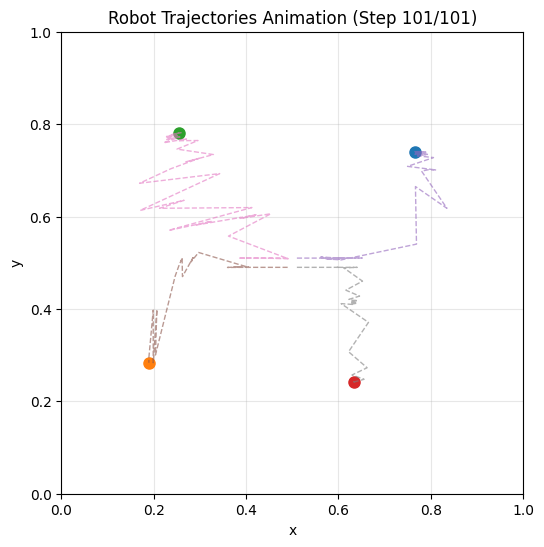

In [173]:
# @title
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

# Assuming 'traj' is a list of arrays, where each array is the state of robots at a timestep
# traj[k] = np.array([[px1, py1, theta1, gamma1], [px2, py2, theta2, gamma2], ...])
# We only need the positions (px, py) for the animation.

T = len(traj)       # Total number of timesteps in the trajectory
M = traj[0].shape[0]  # Number of robots

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, Lx) # Use Lx and Ly from previous cells
ax.set_ylim(0, Ly)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Robot Trajectories Animation')
ax.set_aspect('equal', adjustable='box')
ax.grid(True, alpha=0.3)

# Initialize plots for each robot
robot_plots = [ax.plot([], [], 'o-', markersize=8)[0] for _ in range(M)]
robot_trajectories = [ax.plot([], [], '--', linewidth=1, alpha=0.6)[0] for _ in range(M)]

def init():
    for plot in robot_plots:
        plot.set_data([], [])
    for plot in robot_trajectories:
        plot.set_data([], [])
    return robot_plots + robot_trajectories

def update(frame):
    current_positions = traj[frame][:, :2] # Extract (px, py) for all robots at current frame

    for i in range(M):
        # Update robot position
        robot_plots[i].set_data([current_positions[i, 0]], [current_positions[i, 1]])

        # Update trajectory history (up to current frame)
        x_hist = [t[i, 0] for t in traj[:frame+1]]
        y_hist = [t[i, 1] for t in traj[:frame+1]]
        robot_trajectories[i].set_data(x_hist, y_hist)

    ax.set_title(f'Robot Trajectories Animation (Step {frame+1}/{T})')

    return robot_plots + robot_trajectories

# Create the animation
# interval is in milliseconds
ani = FuncAnimation(fig, update, frames=T, init_func=init, blit=True, interval=50, repeat=False)
# Display the animation as an HTML video
from IPython.display import HTML
HTML(ani.to_jshtml())
#plt.show()

# AI Code

Chatgpt Code

In [ ]:
# @title
# ChatGpt generated
"""
mpcc_coverage_sim.py
Reproduction template for "Model Predictive Coverage Control" (Carron & Zeilinger, IFAC 2020).

- Double-integrator agent: state x = [px, py, vx, vy], input u = [ax, ay]
- MPC: CasADi nonlinear tracking MPC (tracking centroids), quadratic costs
- Voronoi: bounded Voronoi via scipy.spatial + shapely, weighted centroids computed on grid inside cell
- Terminal ingredients: linearize -> discrete LQR via solve_discrete_are -> terminal P, K
- Centroid update rule implements Algorithm 1's conditions
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, Point, box, LineString
from shapely.ops import polygonize, unary_union
from scipy.linalg import solve_discrete_are
import casadi as ca
import time

# -------------------------
# Simulation / model params
# -------------------------
Lx, Ly = 10.0, 10.0           # workspace size
Q_region = box(0, 0, Lx, Ly)
M = 4                         # number of robots
dt = 0.2                      # timestep (s)
sim_steps = 100               # max simulation iterations
grid_density = 30             # grid per cell side for centroid integration (higher -> more accurate)
N_mpc = 10                    # MPC horizon
max_vel = 2.0
max_acc = 1.0

# Cost weights
Q_stage = np.diag([10, 10, 1, 1])   # state error weight
R_stage = 0.1 * np.eye(2)           # input weight
Q_terminal = np.diag([10, 10, 1, 1])

# -------------------------
# Utility: bounded Voronoi
# -------------------------
def bounded_voronoi(polypoints, bbox):
    """
    Compute bounded Voronoi cells for points inside bbox.
    Returns list of shapely Polygons of length = len(polypoints).
    """
    # scipy Voronoi unbounded; we clip cells to bounding box
    pts = np.asarray(polypoints)
    if len(pts) == 1:
        return [bbox]
    vor = Voronoi(pts)
    # build polygon for each region
    regions = []
    for i, point in enumerate(pts):
        region_index = vor.point_region[i]
        region = vor.regions[region_index]
        if -1 in region:  # unbounded region -> clip with bbox
            # approximate by taking voronoi ridges and intersecting rays with bbox edges
            # easier: build large polygon from ridges, then intersect with bbox
            # We'll reconstruct the cell as intersection of half-planes: for each other point j,
            # the halfplane { x | ||x - p_i|| <= ||x - p_j|| }.
            cell = bbox
            pi = point
            for j, pj in enumerate(pts):
                if j == i: continue
                # perpendicular bisector between pi and pj: line ax+by+c=0
                mid = 0.5*(pi + pj)
                # normal vector from pj to pi
                n = np.array(pi) - np.array(pj)
                if np.linalg.norm(n) < 1e-8:
                    continue
                # define a large polygon half-space via a line
                # build a line across bbox and take half that contains pi
                # create a long line segment orthogonal to n passing near mid
                dir_vec = np.array([-n[1], n[0]])
                p1 = mid + dir_vec * max(Lx, Ly) * 10
                p2 = mid - dir_vec * max(Lx, Ly) * 10
                half_line = LineString([tuple(p1), tuple(p2)])
                # create large polygon for half-plane
                coords = [tuple(p1), tuple(p2),
                          (p2[0] + n[0]*1e6, p2[1] + n[1]*1e6),
                          (p1[0] + n[0]*1e6, p1[1] + n[1]*1e6)]
                half_poly = Polygon(coords)
                # choose which half contains pi
                if not half_poly.contains(Point(tuple(pi))):
                    half_poly = Polygon(list(half_poly.exterior.coords)[::-1])
                cell = cell.intersection(half_poly)
                if cell.is_empty:
                    break
            regions.append(cell)
        else:
            polygon = Polygon([vor.vertices[v] for v in region])
            regions.append(polygon.intersection(bbox))
    # ensure order corresponds to input points
    # convert possible GeometryCollections to Polygons
    final = []
    for g in regions:
        if g.geom_type == 'Polygon':
            final.append(g)
        elif g.is_empty:
            final.append(Polygon())
        else:
            # unify and take convex hull fallback
            try:
                gp = unary_union(g)
                final.append(gp.convex_hull.intersection(bbox))
            except Exception:
                final.append(Polygon())
    return final

# -------------------------
# Sensor density (Phi)
# -------------------------
def phi_uniform(xy):
    # uniform density (constant)
    return 1.0

def weighted_centroid_of_polygon(poly, phi=phi_uniform, samples_per_side=20):
    """
    Numerically estimate weighted centroid over polygon using grid sampling.
    Returns centroid (x,y) and mass.
    """
    if poly.is_empty or not poly.is_valid:
        return np.array([np.nan, np.nan]), 0.0
    minx, miny, maxx, maxy = poly.bounds
    if minx == maxx or miny == maxy:
        # degenerate cell
        pts = np.array(poly.exterior.coords)
        c = np.mean(pts, axis=0)
        return c, 1.0
    nx = samples_per_side
    ny = samples_per_side
    xs = np.linspace(minx, maxx, nx)
    ys = np.linspace(miny, maxy, ny)
    X, Y = np.meshgrid(xs, ys)
    pts = np.vstack([X.ravel(), Y.ravel()]).T
    mask = np.array([poly.contains(Point(p)) or poly.touches(Point(p)) for p in pts])
    pts_in = pts[mask]
    if pts_in.shape[0] == 0:
        # fallback centroid of polygon geometry
        c = np.array(poly.representative_point().coords[0])
        return c, 1.0
    vals = np.array([phi(p) for p in pts_in])
    mass = vals.sum()
    if mass == 0:
        c = pts_in.mean(axis=0)
        return c, 0.0
    centroid = (vals[:, None] * pts_in).sum(axis=0) / mass
    return centroid, mass

# -------------------------
# Dynamics and linearization
# -------------------------
def f_dynamics(x, u):
    """Discrete-time double integrator with Euler integration
    state x = [px,py,vx,vy], input u = [ax,ay]
    """
    px, py, vx, vy = x
    ax, ay = u
    px_next = px + vx * dt
    py_next = py + vy * dt
    vx_next = vx + ax * dt
    vy_next = vy + ay * dt
    return np.array([px_next, py_next, vx_next, vy_next])

def clip_state(x):
    # position inside Q, velocity limits
    x = x.copy()
    x[0] = np.clip(x[0], 0, Lx)
    x[1] = np.clip(x[1], 0, Ly)
    x[2] = np.clip(x[2], -max_vel, max_vel)
    x[3] = np.clip(x[3], -max_vel, max_vel)
    return x

# Linearization at equilibrium (zero pos -> choose equilibrium at v=0, a=0)
A_ct = np.array([[0,0,1,0],
                 [0,0,0,1],
                 [0,0,0,0],
                 [0,0,0,0]])
B_ct = np.array([[0,0],
                 [0,0],
                 [1,0],
                 [0,1]])
# discrete approx (Euler)
A = np.eye(4) + A_ct*dt
B = B_ct * dt

# Terminal controller via discrete LQR (Algorithm 2)
def compute_terminal_lqr(A, B, Qc, Rc):
    P = solve_discrete_are(A, B, Qc, Rc)
    K = -np.linalg.inv(B.T @ P @ B + Rc) @ (B.T @ P @ A)
    return P, K

P_term, K_term = compute_terminal_lqr(A, B, Q_terminal, R_stage)

# -------------------------
# CasADi MPC builder
# -------------------------
def build_mpc_problem(N=N_mpc):
    nx = 4
    nu = 2
    X = ca.SX.sym('X', nx, N+1)
    U = ca.SX.sym('U', nu, N)
    x0 = ca.SX.sym('x0', nx)
    xbar = ca.SX.sym('xbar', nx)  # steady state to track
    ubar = ca.SX.sym('ubar', nu)
    # stage cost matrices as CasADi
    Qc = ca.DM(Q_stage)
    Rc = ca.DM(R_stage)
    QN = ca.DM(Q_terminal)
    obj = 0
    g = []
    # initial cond
    g.append(X[:,0] - x0)
    for k in range(N):
        # dynamics: explicit Euler discrete mapping f_dynamics
        x_next = ca.vertcat(X[0,k] + X[2,k]*dt,
                            X[1,k] + X[3,k]*dt,
                            X[2,k] + U[0,k]*dt,
                            X[3,k] + U[1,k]*dt)
        g.append(X[:,k+1] - x_next)
        dx = X[:,k] - xbar
        du = U[:,k] - ubar
        obj = obj + ca.mtimes([dx.T, Qc, dx]) + ca.mtimes([du.T, Rc, du])
    # terminal cost
    dxN = X[:,N] - xbar
    obj = obj + ca.mtimes([dxN.T, QN, dxN])
    # bounds and constraints will be added in solver call (as functions)
    # pack decision vars
    dec_vars = ca.vertcat(ca.reshape(X, -1, 1), ca.reshape(U, -1, 1))
    # build function to extract objective and constraints for a given x0,xbar,ubar
    fun_obj = ca.Function('obj', [dec_vars, x0, xbar, ubar], [obj])
    fun_g = ca.Function('g', [dec_vars, x0, xbar, ubar], [ca.vertcat(*g)])
    return fun_obj, fun_g, nx, nu, N

fun_obj, fun_g, NX, NU, Nmpc = build_mpc_problem(N_mpc)

# Helper to solve MPC via CasADi's NLP interface (we formulate whole NLP each call)
def solve_mpc_casadi(x0_val, xbar_val, ubar_val, N=N_mpc):
    """
    Build a small NLP each call. For clarity and simplicity we rebuild constraints inline using CasADi.
    For performance, a compiled solver/interface would be better (keep solver object), but this template is clear.
    """
    nx = 4; nu = 2
    # decision var shapes
    X = ca.SX.sym('X', nx, N+1)
    U = ca.SX.sym('U', nu, N)
    dec = ca.vertcat(ca.reshape(X, -1, 1), ca.reshape(U, -1, 1))
    x0 = ca.SX.sym('x0', nx)
    xbar = ca.SX.sym('xbar', nx)
    ubar = ca.SX.sym('ubar', nu)
    Qc = ca.DM(Q_stage); Rc = ca.DM(R_stage); QN = ca.DM(Q_terminal)
    obj = 0
    g = []
    g.append(X[:,0] - x0)
    for k in range(N):
        x_next = ca.vertcat(X[0,k] + X[2,k]*dt,
                            X[1,k] + X[3,k]*dt,
                            X[2,k] + U[0,k]*dt,
                            X[3,k] + U[1,k]*dt)
        g.append(X[:,k+1] - x_next)
        dx = X[:,k] - xbar
        du = U[:,k] - ubar
        obj = obj + ca.mtimes([dx.T, Qc, dx]) + ca.mtimes([du.T, Rc, du])
    dxN = X[:,N] - xbar
    obj = obj + ca.mtimes([dxN.T, QN, dxN])

    # constraints: box constraints on positions and velocities and acceleration limits
    g_all = ca.vertcat(*g)
    nlp = {'x':dec, 'f':obj, 'g':g_all, 'p':ca.vertcat(x0, xbar, ubar)}
    opts = {'ipopt.print_level':0, 'print_time':0}
    solver = ca.nlpsol('solver', 'ipopt', nlp, opts)

    # initial guess
    x_init = np.tile(x0_val.reshape(-1,1), (1, N+1))
    u_init = np.zeros((nu, N))
    dec_init = np.vstack([x_init.reshape(-1,1), u_init.reshape(-1,1)])
    # bounds for g (dynamics equality)
    ng = g_all.size1()
    lbg = np.zeros((ng,1))
    ubg = np.zeros((ng,1))
    # bounds for dec vars: we won't impose here; instead we later clip applied input
    p_val = np.vstack([x0_val.reshape(-1,1), xbar_val.reshape(-1,1), ubar_val.reshape(-1,1)])
    try:
        sol = solver(x0=dec_init, lbg=lbg, ubg=ubg, p=p_val)
        dec_sol = sol['x'].full().flatten()
        # extract first control
        x_vars = dec_sol[:nx*(N+1)].reshape((nx, N+1))
        u_vars = dec_sol[nx*(N+1):].reshape((nu, N))
        u0 = u_vars[:,0]
    except Exception as e:
        # infeasible or solver failure -> fallback to zero accel
        # print("MPC solver failed:", e)
        u0 = np.zeros(2)
    # clip inputs
    u0 = np.clip(u0, -max_acc, max_acc)
    return u0

# -------------------------
# Main sim initialization
# -------------------------
np.random.seed(2)
# initial robot states: random positions, zero velocity
x = np.zeros((M, 4))
x[:, 0:2] = np.random.rand(M, 2) * np.array([Lx, Ly])
# initial references (centroids) computed from initial Voronoi
ps = x[:, :2].copy()
cells = bounded_voronoi(ps, Q_region)
centroids = np.zeros((M,2))
mass_list = np.zeros(M)
for i in range(M):
    c, mass = weighted_centroid_of_polygon(cells[i], phi_uniform, samples_per_side=grid_density)
    if mass == 0:
        c = ps[i]
    centroids[i] = c
    mass_list[i] = mass
# per-agent tracking error initial
e_r = np.linalg.norm(ps - centroids, axis=1)

# logging
traj = [ps.copy()]
H_vals = []

# small helper for coverage cost approx H(p,W) using Monte Carlo grid
def approx_coverage_cost(points, cells, phi=phi_uniform, gfun=lambda d: d**2, samples=400):
    # approximate integral by sampling a grid over workspace
    xs = np.linspace(0, Lx, int(np.sqrt(samples)))
    ys = np.linspace(0, Ly, int(np.sqrt(samples)))
    X, Y = np.meshgrid(xs, ys)
    pts = np.vstack([X.ravel(), Y.ravel()]).T
    total = 0.0
    for p_i, cell in zip(points, cells):
        # pick samples inside cell
        mask = np.array([cell.contains(Point(pt)) or cell.touches(Point(pt)) for pt in pts])
        if mask.sum() == 0:
            continue
        pts_in = pts[mask]
        dists = np.linalg.norm(pts_in - p_i, axis=1)
        vals = gfun(dists) * np.array([phi(pt) for pt in pts_in])
        total += vals.mean() * cell.area
    return total

# -------------------------
# Simulation loop (Algorithm 1)
# -------------------------
print("Starting simulation...")
start_time = time.time()
for k in range(sim_steps):
    # compute Voronoi and centroids (based on current positions)
    ps = x[:, :2].copy()
    cells = bounded_voronoi(ps, Q_region)
    centroids_current = np.zeros((M,2))
    masses = np.zeros(M)
    for i in range(M):
        c, mass = weighted_centroid_of_polygon(cells[i], phi_uniform, samples_per_side=grid_density)
        if mass == 0:
            c = ps[i]
        centroids_current[i] = c
        masses[i] = mass

    # for each agent: compute MPC to track its current reference ri (which is centroids[i] from last update)
    # The algorithm in the paper sets ri to computed centroid at initialization, then only updates ri when condition met.
    # To mimic that, we will store ri, ei,r, and update ri only when condition satisfied.
    # For start: if first iteration, we set ri as previously computed centroids (done above at init)
    if k == 0:
        ri = centroids.copy()
    # apply MPC for each agent to track ri[i]
    for i in range(M):
        x0 = x[i].copy()
        # build xbar (steady state) from ri: we choose steady state with zero velocity, so xbar = [rx, ry, 0,0]
        xbar = np.array([ri[i,0], ri[i,1], 0., 0.])
        ubar = np.zeros(2)
        # solve MPC
        u0 = solve_mpc_casadi(x0, xbar, ubar, N_mpc)
        # apply input, propagate dynamics
        x_next = f_dynamics(x0, u0)
        x_next = clip_state(x_next)
        x[i] = x_next
    # After all agents applied first input, compute condition for updating ri (lines 8-10)
    ps_new = x[:, :2].copy()
    # check not-increased condition
    dist_to_ri = np.linalg.norm(ps_new - ri, axis=1)
    non_increase = np.all(dist_to_ri <= e_r + 1e-9)
    decreased_any = np.any(dist_to_ri < e_r - 1e-9)
    if non_increase and decreased_any:
        # update ri to new centroids computed from current positions (centroids_current)
        ri = centroids_current.copy()
        e_r = np.linalg.norm(ps_new - ri, axis=1)
        # (this is centralized step in algorithm)
    else:
        # keep e_r as distances to current ri if not updated
        e_r = dist_to_ri.copy()

    # log
    traj.append(x[:, :2].copy())
    H_vals.append(approx_coverage_cost(ps_new, cells, phi_uniform, gfun=lambda d: d**2, samples=400))
    # stop if robots near centroids (converged)
    if np.max(np.linalg.norm(ps_new - centroids_current, axis=1)) < 0.05:
        print(f"Converged by iteration {k}")
        break

end_time = time.time()
print("Simulation finished in {:.2f}s".format(end_time - start_time))

# -------------------------
# Visualization
# -------------------------
traj = np.array(traj)  # (T, M, 2)
T = traj.shape[0]

plt.figure(figsize=(8,8))
# plot workspace
plt.xlim(0, Lx); plt.ylim(0, Ly)
# plot trajectories
for i in range(M):
    plt.plot(traj[:, i, 0], traj[:, i, 1], '-', linewidth=1)
    plt.scatter(traj[0, i, 0], traj[0, i, 1], marker='o', label=f'robot{i}' if i==0 else None)
    plt.scatter(traj[-1, i, 0], traj[-1, i, 1], marker='x')
# plot final Voronoi
final_cells = bounded_voronoi(traj[-1,:,:], Q_region)
for c in final_cells:
    if not c.is_empty:
        xs, ys = c.exterior.xy
        plt.plot(xs, ys, 'k--', linewidth=0.7)
# final centroids
final_centroids = np.array([weighted_centroid_of_polygon(c, phi_uniform, grid_density)[0] for c in final_cells])
plt.scatter(final_centroids[:,0], final_centroids[:,1], marker='*', s=120, c='r', label='centroids')
plt.title('Trajectories and final Voronoi')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

plt.figure()
plt.plot(H_vals)
plt.title('Approximate coverage cost H(p,W) over time')
plt.xlabel('iteration')
plt.ylabel('H')
plt.grid(True)
plt.show()


Claude Code

In [ ]:
# @title
# Claude generated
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

class BicycleRobot:
    """Bicycle model robot dynamics"""
    def __init__(self, initial_state, L=0.005, Ts=0.1):
        self.state = np.array(initial_state)  # [px, py, theta, gamma]
        self.L = L  # wheelbase
        self.Ts = Ts  # sampling time

    def dynamics(self, state, control):
        """Discrete-time bicycle model dynamics"""
        px, py, theta, gamma = state
        v, delta = control

        px_next = px + self.Ts * np.cos(theta) * v
        py_next = py + self.Ts * np.sin(theta) * v
        theta_next = theta + self.Ts * np.tan(gamma) * v / self.L
        gamma_next = gamma + self.Ts * delta

        return np.array([px_next, py_next, theta_next, gamma_next])

    def get_position(self):
        return self.state[:2]

class VoronoiCoverage:
    """Voronoi partitioning and centroid computation"""
    def __init__(self, Q_bounds=[[0, 1], [0, 1]]):
        self.Q_bounds = Q_bounds

    def compute_voronoi(self, positions):
        """Compute Voronoi partition for given robot positions"""
        return Voronoi(positions)

    def compute_centroid(self, robot_idx, positions):
        """Compute centroid of Voronoi region for robot i"""
        vor = self.compute_voronoi(positions)
        region_idx = vor.point_region[robot_idx]
        vertex_indices = vor.regions[region_idx]

        if -1 in vertex_indices:
            # Unbounded region - use bounded approximation
            return self._bounded_centroid(robot_idx, positions)

        vertices = vor.vertices[vertex_indices]

        # Clip vertices to Q bounds
        vertices = self._clip_to_bounds(vertices)

        # Compute centroid (assuming uniform density)
        if len(vertices) > 0:
            centroid = np.mean(vertices, axis=0)
            # Ensure centroid is within bounds
            centroid = np.clip(centroid,
                             [self.Q_bounds[0][0], self.Q_bounds[1][0]],
                             [self.Q_bounds[0][1], self.Q_bounds[1][1]])
            return centroid
        else:
            return positions[robot_idx]

    def _clip_to_bounds(self, vertices):
        """Clip vertices to Q bounds"""
        clipped = []
        for v in vertices:
            if (self.Q_bounds[0][0] <= v[0] <= self.Q_bounds[0][1] and
                self.Q_bounds[1][0] <= v[1] <= self.Q_bounds[1][1]):
                clipped.append(v)
        return np.array(clipped) if clipped else vertices

    def _bounded_centroid(self, robot_idx, positions):
        """Compute centroid for bounded region approximation"""
        # Simple approximation: use position or move toward center of uncovered area
        return positions[robot_idx]

class SimplifiedMPC:
    """Simplified MPC controller for tracking"""
    def __init__(self, robot, N=10, Q_weight=10.0, R_weight=1.0):
        self.robot = robot
        self.N = N  # prediction horizon
        self.Q = Q_weight * np.eye(4)
        self.R = R_weight * np.eye(2)

        # Constraints
        self.v_max = 1.0
        self.delta_max = 1.0
        self.gamma_max = np.pi / 2.1

    def solve(self, current_state, reference_position):
        """Solve MPC optimization problem"""
        # Initial guess
        u0 = np.zeros(2 * self.N)

        # Target state (position at reference, zero angles and velocities)
        target_state = np.array([reference_position[0], reference_position[1], 0, 0])

        # Cost function
        def cost(u):
            u_seq = u.reshape((self.N, 2))
            state = current_state.copy()
            total_cost = 0

            for i in range(self.N):
                # State cost
                state_error = state - target_state
                total_cost += state_error.T @ self.Q @ state_error

                # Control cost
                total_cost += u_seq[i].T @ self.R @ u_seq[i]

                # Propagate dynamics
                state = self.robot.dynamics(state, u_seq[i])

            # Terminal cost
            state_error = state - target_state
            total_cost += state_error.T @ (10 * self.Q) @ state_error

            return total_cost

        # Constraints
        bounds = []
        for _ in range(self.N):
            bounds.append((-self.v_max, self.v_max))
            bounds.append((-self.delta_max, self.delta_max))

        # Solve optimization
        result = minimize(cost, u0, method='SLSQP', bounds=bounds,
                         options={'maxiter': 100, 'ftol': 1e-4})

        u_opt = result.x.reshape((self.N, 2))
        return u_opt[0]  # Return first control input

def compute_coverage_cost(positions, Q_bounds=[[0, 1], [0, 1]]):
    """Compute coverage cost function H(p, W)"""
    vor = Voronoi(positions)
    total_cost = 0

    for i, pos in enumerate(positions):
        region_idx = vor.point_region[i]
        vertex_indices = vor.regions[region_idx]

        if -1 not in vertex_indices and len(vertex_indices) > 0:
            vertices = vor.vertices[vertex_indices]
            # Simple cost approximation: integral of squared distance
            for v in vertices:
                if (Q_bounds[0][0] <= v[0] <= Q_bounds[0][1] and
                    Q_bounds[1][0] <= v[1] <= Q_bounds[1][1]):
                    total_cost += np.linalg.norm(v - pos)**2

    return total_cost

def plot_voronoi_coverage(positions, Q_bounds, iteration, ax):
    """Plot Voronoi partition and robot positions"""
    ax.clear()

    # Plot Voronoi diagram
    vor = Voronoi(positions)
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='black',
                    line_width=2, line_alpha=0.6, point_size=0)

    # Plot robot positions
    ax.plot(positions[:, 0], positions[:, 1], 'bo', markersize=10, label='Robots')

    # Plot centroids
    voronoi_coverage = VoronoiCoverage(Q_bounds)
    centroids = []
    for i in range(len(positions)):
        c = voronoi_coverage.compute_centroid(i, positions)
        centroids.append(c)
    centroids = np.array(centroids)
    ax.plot(centroids[:, 0], centroids[:, 1], 'g*', markersize=15, label='Centroids')

    ax.set_xlim(Q_bounds[0])
    ax.set_ylim(Q_bounds[1])
    ax.set_aspect('equal')
    ax.set_xlabel('$p_x$')
    ax.set_ylabel('$p_y$')
    ax.set_title(f'Iteration {iteration}')
    ax.legend()
    ax.grid(True, alpha=0.3)

def main():
    # Environment setup
    Q_bounds = [[0, 1], [0, 1]]

    # Initialize robots
    initial_positions = [
        [0.05, 0.15, 0, 0],  # [px, py, theta, gamma]
        [0.1, 0.15, 0, 0],
        [0.25, 0.35, 0, 0],
        [0.3, 0.1, 0, 0]
    ]

    robots = [BicycleRobot(pos) for pos in initial_positions]
    voronoi_coverage = VoronoiCoverage(Q_bounds)
    mpcs = [SimplifiedMPC(robot, N=5) for robot in robots]

    # Initialize references and tracking errors
    positions = np.array([robot.get_position() for robot in robots])
    references = [voronoi_coverage.compute_centroid(i, positions) for i in range(len(robots))]
    tracking_errors = [np.linalg.norm(positions[i] - references[i]) for i in range(len(robots))]

    # Simulation parameters
    max_iterations = 100
    coverage_costs = []

    # Storage for trajectories
    trajectories = [[] for _ in range(len(robots))]

    # Create figure for animation
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    print("Starting Model Predictive Coverage Control simulation...")

    for k in range(max_iterations):
        # Get current positions
        positions = np.array([robot.get_position() for robot in robots])

        # Store trajectories
        for i, pos in enumerate(positions):
            trajectories[i].append(pos.copy())

        # Compute coverage cost
        cost = compute_coverage_cost(positions, Q_bounds)
        coverage_costs.append(cost)

        # Each robot solves MPC and applies control
        for i, (robot, mpc) in enumerate(zip(robots, mpcs)):
            u_opt = mpc.solve(robot.state, references[i])
            robot.state = robot.dynamics(robot.state, u_opt)

        # Check if references should be updated
        positions = np.array([robot.get_position() for robot in robots])
        current_errors = [np.linalg.norm(positions[i] - references[i]) for i in range(len(robots))]

        all_decreased = all(current_errors[i] <= tracking_errors[i] for i in range(len(robots)))
        at_least_one_strict = any(current_errors[i] < tracking_errors[i] for i in range(len(robots)))

        if all_decreased and at_least_one_strict:
            # Update references
            references = [voronoi_coverage.compute_centroid(i, positions) for i in range(len(robots))]
            tracking_errors = current_errors.copy()
            print(f"Iteration {k}: References updated")

        # Plot at specific iterations
        if k in [0, 9, 19, 99] or k == max_iterations - 1:
            plot_voronoi_coverage(positions, Q_bounds, k, ax1)
            plt.pause(0.1)

    # Final plots
    plot_voronoi_coverage(positions, Q_bounds, max_iterations, ax1)

    # Plot coverage cost evolution
    ax2.plot(coverage_costs, 'b-', linewidth=2)
    ax2.set_xlabel('Iteration number')
    ax2.set_ylabel('Coverage cost')
    ax2.set_title('Evolution of Coverage Cost')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('mpcc_results.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Plot trajectories
    fig, ax = plt.subplots(figsize=(8, 8))
    positions = np.array([robot.get_position() for robot in robots])
    plot_voronoi_coverage(positions, Q_bounds, max_iterations, ax)

    # Add trajectories
    colors = ['r', 'b', 'g', 'm']
    for i, traj in enumerate(trajectories):
        traj = np.array(traj)
        ax.plot(traj[:, 0], traj[:, 1], colors[i]+'--', linewidth=1.5, alpha=0.6)

    ax.set_title('Robot Trajectories and Final Voronoi Partition')
    plt.savefig('mpcc_trajectories.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\nSimulation completed!")
    print(f"Final coverage cost: {coverage_costs[-1]:.4f}")
    print(f"Initial coverage cost: {coverage_costs[0]:.4f}")

if __name__ == "__main__":
    main()